## Preliminary Analysis and Baseline

### B1. Data Acquisition and Loading

The dataset used in this project is the CICIDS-2017 Intrusion Detection Dataset developed by the Canadian Institute for Cybersecurity at the University of New Brunswick. It contains five days of simulated enterprise network traffic that include both normal user activity and various cyberattack scenarios such as brute-force login attempts, denial-of-service events, infiltration, botnet activity, and port scanning. The raw network packets were captured in PCAP format and processed using CICFlowMeter, which transformed them into flow-based records and calculated over eighty statistical features describing traffic behavior, including packet counts, byte rates, flow durations, and timing statistics. The resulting dataset provides millions of labeled network flows representing both benign and malicious traffic, making it suitable for supervised machine learning tasks aimed at detecting intrusions.

In [44]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from pathlib import Path
import matplotlib.pyplot as plt

In [26]:
# Load the data set in 
network = pd.read_csv("~/CMSE492/cmse492_project/data/raw/friday.csv")

network.columns = (
    network.columns.str.strip().str.replace(' ', '_').str.replace('/', '_per_').str.replace('(', '', regex=False).str.replace(')', '', regex=False))

# Display first few rows
network.head()

,Src_IP_dec,Src_Port,Dst_IP_dec,Dst_Port,Protocol,Timestamp,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,...,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,ICMP_Code,ICMP_Type,Total_TCP_Flow_Time,Label,Attempted_Category
0,3232238130,56108,3232238083,3268,6,59:50.3,112740690,32,16,6448,...,343,16105402.14,4.988048e+05,16399772,15375229,-1,-1,112740690,BENIGN,-1
1,3232238130,42144,3232238083,389,6,59:50.3,112740560,32,16,6448,...,285,16105427.43,4.987937e+05,16399782,15375263,-1,-1,112740560,BENIGN,-1
2,134610945,0,134219268,0,0,00:31.4,113757377,545,0,0,...,19,12210358.40,6.935824e+06,20757030,5504997,-1,-1,0,BENIGN,-1
3,3232238105,5353,3758096635,5353,17,00:42.9,91997219,388,0,37151,...,16,13197637.00,5.826905e+06,19776791,5817470,-1,-1,0,BENIGN,-1
4,3232238105,123,301796989,123,17,00:42.4,66966070,6,6,288,...,1968172,64974431.00,0.000000e+00,64974431,64974431,-1,-1,0,BENIGN,-1


In [27]:
network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547557 entries, 0 to 547556
Data columns (total 89 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Src_IP_dec                  547557 non-null  int64  
 1   Src_Port                    547557 non-null  int64  
 2   Dst_IP_dec                  547557 non-null  int64  
 3   Dst_Port                    547557 non-null  int64  
 4   Protocol                    547557 non-null  int64  
 5   Timestamp                   547557 non-null  object 
 6   Flow_Duration               547557 non-null  int64  
 7   Total_Fwd_Packet            547557 non-null  int64  
 8   Total_Bwd_packets           547557 non-null  int64  
 9   Total_Length_of_Fwd_Packet  547557 non-null  int64  
 10  Total_Length_of_Bwd_Packet  547557 non-null  int64  
 11  Fwd_Packet_Length_Max       547557 non-null  int64  
 12  Fwd_Packet_Length_Min       547557 non-null  int64  
 13  Fwd_Packet_Len

In [28]:
network.describe()

,Src_IP_dec,Src_Port,Dst_IP_dec,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,...,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,ICMP_Code,ICMP_Type,Total_TCP_Flow_Time,Attempted_Category
count,5.475570e+05,547557.000000,5.475570e+05,547557.000000,547557.000000,5.475570e+05,547557.000000,547557.000000,547557.000000,5.475570e+05,...,5.475570e+05,5.475570e+05,5.475570e+05,5.475570e+05,5.475570e+05,5.475570e+05,547557.000000,547557.000000,5.475570e+05,547557.000000
mean,3.070415e+09,47158.825030,2.996277e+09,2826.089161,9.785144,9.252255e+06,8.726116,9.444566,374.740299,1.408719e+04,...,2.023936e+05,1.125818e+05,3.610678e+06,1.455170e+05,3.716373e+06,3.451524e+06,-0.999262,-0.998444,1.561664e+07,-0.985145
std,1.826780e+08,16039.868513,6.837863e+08,8604.258903,5.233530,2.609339e+07,648.644128,874.427110,3088.263160,1.958688e+06,...,1.071617e+06,6.682971e+05,1.149280e+07,1.870863e+06,1.182962e+07,1.131402e+07,0.050051,0.093615,1.899453e+08,0.171725
min,1.346109e+08,0.000000,1.686074e+07,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00,-1.000000
25%,2.886730e+09,39606.000000,3.232238e+09,53.000000,6.000000,7.100000e+01,1.000000,1.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,0.000000e+00,-1.000000
50%,3.232238e+09,52332.000000,3.232238e+09,80.000000,6.000000,3.114100e+04,2.000000,2.000000,41.000000,1.680000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,4.800000e+01,-1.000000
75%,3.232238e+09,59207.000000,3.232238e+09,1055.000000,17.000000,5.032396e+06,8.000000,5.000000,88.000000,4.158000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-1.000000,4.507917e+06,-1.000000
max,3.524167e+09,65535.000000,4.294967e+09,65525.000000,17.000000,1.200000e+08,207963.000000,284603.000000,624776.000000,6.270395e+08,...,1.100975e+08,1.100975e+08,1.199912e+08,7.663521e+07,1.199912e+08,1.199912e+08,10.000000,8.000000,2.676050e+10,1.000000


In [56]:
selected_features = [
    'Flow_Duration',             # Overall connection time
    'Total_Fwd_Packet',          # Packets sent forward
    'Total_Bwd_packets',         # Packets received backward
    'Flow_Bytes_per_s',          # Data throughput
    'Flow_Packets_per_s',        # Packet rate
    'Packet_Length_Mean',        # Average packet size
    'Active_Mean',               # Mean of active flow time
    'Idle_Mean'                  # Mean of idle flow time
]

# --- Generate and format the summary statistics ---
summary_stats = network[selected_features].describe().T.round(2)
summary_stats = summary_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
display(summary_stats)


,count,mean,std,min,25%,50%,75%,max
Flow_Duration,547557.0,9252255.05,26093392.63,1.00,71.0,31141.00,5032396.00,1.200000e+08
Total_Fwd_Packet,547557.0,8.73,648.64,0.00,1.0,2.00,8.00,2.079630e+05
Total_Bwd_packets,547557.0,9.44,874.43,0.00,1.0,2.00,5.00,2.846030e+05
Flow_Bytes_per_s,547557.0,337176.40,3324236.31,0.00,0.0,1226.60,6368.10,1.781765e+08
Flow_Packets_per_s,547557.0,24213.94,94546.86,0.03,3.0,107.14,28985.51,2.000000e+06
Packet_Length_Mean,547557.0,224.57,333.10,0.00,0.0,68.50,225.28,2.090110e+03
Active_Mean,547557.0,133760.66,733984.91,0.00,0.0,0.00,0.00,1.100975e+08
Idle_Mean,547557.0,3610677.94,11492795.78,0.00,0.0,0.00,0.00,1.199912e+08


In [29]:
# Saving a sample to processed
sample = network.sample(n=1000, random_state=42)
sample.to_csv("~/CMSE492/cmse492_project/data/processed/sample_friday.csv", index=False)

### B2. Initial Exploratory Data Analysis

The first visual is the class balance plot, which is a good first step in understanding the dataset. It provides a clear view of how the benign and attack traffic are distributed, showing that the data is highly imbalanced with far more benign flows than malicious ones.

The second visual is the flow duration distribution, which reveals that most network flows are short in duration while only a small fraction last significantly longer. This skew indicates the presence of bursty traffic patterns typical in certain attack behaviors.

The third visual is the correlation matrix, which highlights relationships among key numeric features such as flow duration, total packet counts, and byte rates. Strong positive correlations between packet and byte features suggest potential redundancy that may need to be addressed during feature selection.

The fourth visual is the scatter plot of flow duration versus total forward packets, which shows the relationship between connection length and packet count for benign and attack traffic. Attack flows often cluster at shorter durations with higher packet counts, while normal traffic appears more evenly distributed, emphasizing behavioral differences useful for classification.

In [30]:
# From end example in book how to save figures to figure directory 

PROJECT_ROOT = Path.cwd().parents[1] 
FIGURES_PATH = PROJECT_ROOT / "figures"
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = FIGURES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

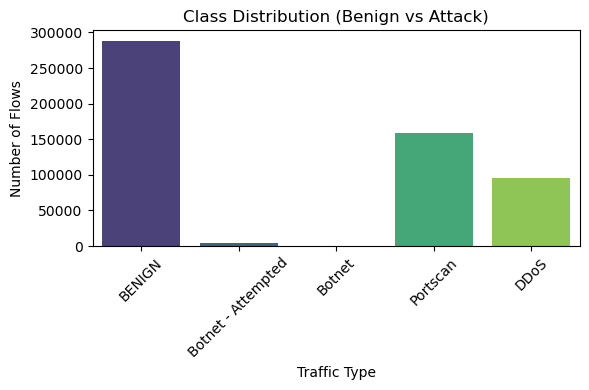

In [31]:
# Class balance plot

plt.figure(figsize=(6,4))
sns.countplot(x='Label', hue='Label', data=network, palette='viridis', legend=False)
plt.title("Class Distribution (Benign vs Attack)")
plt.xlabel("Traffic Type")
plt.ylabel("Number of Flows")
plt.xticks(rotation=45)
plt.tight_layout()

# Saving to figures directory
save_fig("class_distribution")
plt.show()

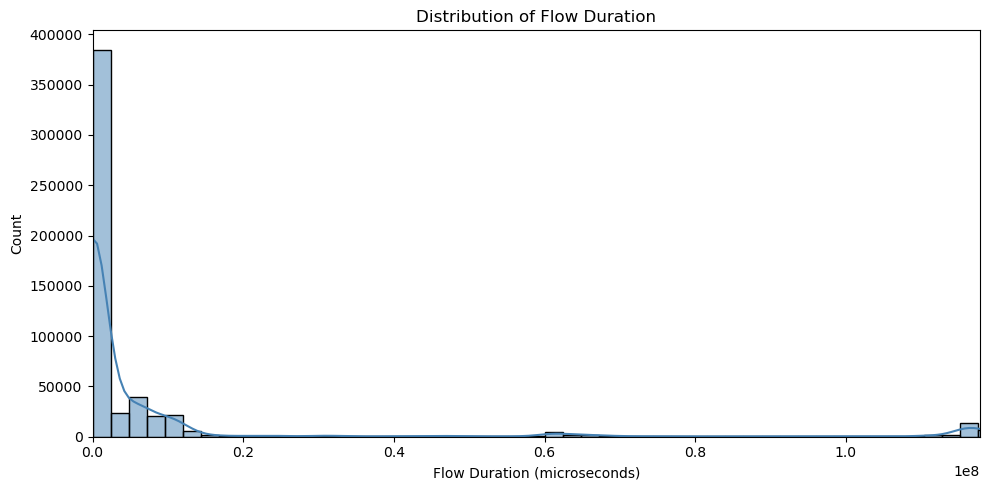

In [35]:
# Distribution of flow duration

plt.figure(figsize=(10,5))
sns.histplot(network['Flow_Duration'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Flow Duration")
plt.xlabel("Flow Duration (microseconds)")
plt.ylabel("Count")
plt.xlim(0, network['Flow_Duration'].quantile(0.99))
plt.tight_layout()

# Saving to figures directory
save_fig("flow_duration_distribution")
plt.show()

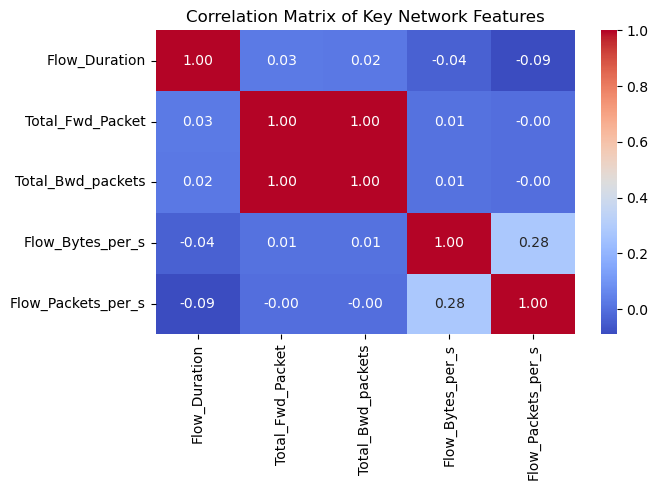

In [37]:
features = ['Flow_Duration', 'Total_Fwd_Packet', 'Total_Bwd_packets',
            'Flow_Bytes_per_s', 'Flow_Packets_per_s']
corr = network[features].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Key Network Features")
plt.tight_layout()

# Saving to figures directory
save_fig("feature_correlation_heatmap")
plt.show()

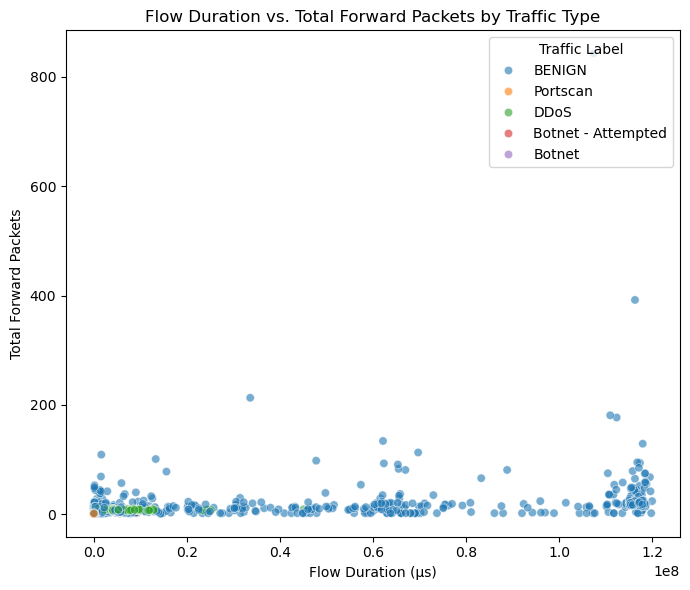

In [38]:
# Relationship Between Flow Duration and Packet Count

plt.figure(figsize=(7,6))
sns.scatterplot(x='Flow_Duration',y='Total_Fwd_Packet',hue='Label',data=network.sample(5000, random_state=42),alpha=0.6)
plt.title("Flow Duration vs. Total Forward Packets by Traffic Type")
plt.xlabel("Flow Duration (μs)")
plt.ylabel("Total Forward Packets")
plt.legend(title="Traffic Label", loc='upper right')
plt.tight_layout()

save_fig("flow_duration_vs_fwd_packets")
plt.show()

### B3. Baseline Model 

For the baseline model, a simple logistic regression was implemented using a subset of core flow features. The model achieved modest performance, serving as a reference point for later optimization and feature engineering stages. A majority class dummy classifier was also included for comparison, confirming that the logistic regression provides measurable improvement over random or naive predictions.

The baseline logistic regression achieved an accuracy of approximately 0.53, which is equivalent to the majority-class dummy classifier. However, the model failed to correctly identify any attack instances, resulting in precision and recall scores of 0.0 for the minority class. This outcome reflects the severe class imbalance in the dataset, where benign traffic dominates. Although the ROC AUC score of 0.82 indicates that the model assigns somewhat different probabilities to benign and attack traffic, its classification threshold does not yet capture minority cases. This baseline provides a useful reference for future improvements through feature scaling, class rebalancing, and hyperparameter tuning.

In [40]:
# Logistic Regression

network['Label'] = network['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

features = ['Flow_Duration', 'Total_Fwd_Packet', 'Total_Bwd_packets', 'Flow_Bytes_per_s']
X = network[features]
y = network['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [51]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Dummy accuracy:", round(dummy.score(X_test, y_test),5))

Dummy accuracy: 0.52697


In [53]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("Accuracy:", log_reg.score(X_test, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3,zero_division=0))

Accuracy: 0.5269681252587235
ROC-AUC: 0.825479308788019
              precision    recall  f1-score   support

           0      0.527     1.000     0.690     86564
           1      0.000     0.000     0.000     77704

    accuracy                          0.527    164268
   macro avg      0.263     0.500     0.345    164268
weighted avg      0.278     0.527     0.364    164268



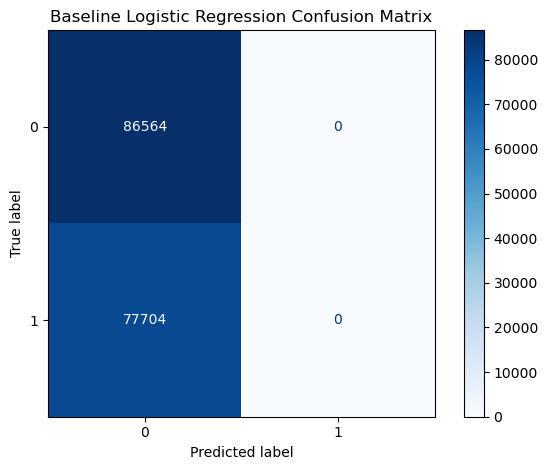

In [52]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues')
plt.title("Baseline Logistic Regression Confusion Matrix")
save_fig("baseline_confusion_matrix")
plt.show()

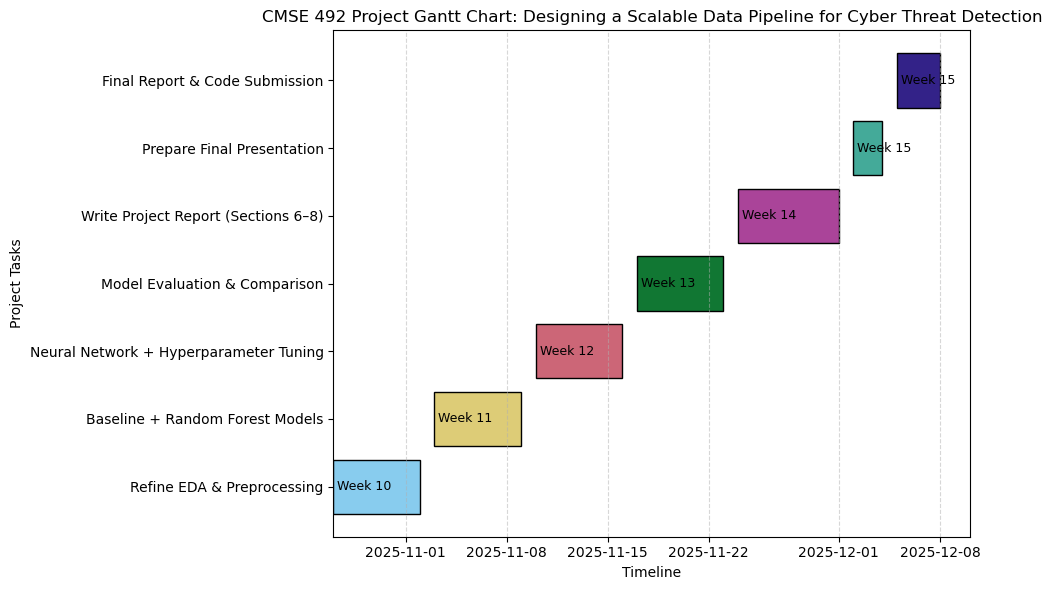

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# --- Define your project schedule ---
tasks = [
    # Week, Start, End, Task, Category, Color
    ("Week 10", "2025-10-27", "2025-11-02", "Refine EDA & Preprocessing", "Data Prep", "#88CCEE"),
    ("Week 11", "2025-11-03", "2025-11-09", "Baseline + Random Forest Models", "Model Dev", "#DDCC77"),
    ("Week 12", "2025-11-10", "2025-11-16", "Neural Network + Hyperparameter Tuning", "Model Dev", "#CC6677"),
    ("Week 13", "2025-11-17", "2025-11-23", "Model Evaluation & Comparison", "Evaluation", "#117733"),
    ("Week 14", "2025-11-24", "2025-12-01", "Write Project Report (Sections 6–8)", "Reporting", "#AA4499"),
    ("Week 15", "2025-12-02", "2025-12-04", "Prepare Final Presentation", "Presentation", "#44AA99"),
    ("Week 15", "2025-12-05", "2025-12-08", "Final Report & Code Submission", "Submission", "#332288"),
]

df = pd.DataFrame(tasks, columns=["Week", "Start", "End", "Task", "Category", "Color"])
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in enumerate(df.itertuples()):
    ax.barh(row.Task, (row.End - row.Start).days, left=row.Start, color=row.Color, edgecolor='black')
    ax.text(row.Start, i, f" {row.Week}", va='center', fontsize=9, color='black')

ax.set_xlabel("Timeline")
ax.set_ylabel("Project Tasks")
ax.set_title("CMSE 492 Project Gantt Chart: Designing a Scalable Data Pipeline for Cyber Threat Detection")
ax.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# --- Save the figure ---
save_fig("project_timeline")
plt.show()
